# Single taxil calibration
This notebook implements a model to calibrate a single taxel

In [133]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import numpy as np

# Parameters
SENSOR_LAG = 25 # ms
TAXEL_INDEX = 3
ARRAY_SIZE = 2*2
NAME = "H1_5_s" + str(TAXEL_INDEX)
ANGLE_CLIP_THRESHOLD = 0.1

In [134]:
TF_file = f'../scripts/FT300-S_force_torque/data/{NAME}.csv'
sensor_file = f'../scripts/2x2_sensor/data/{NAME}.csv'

# Load the data from the CSV file into a pandas DataFrame
TFdata = pd.read_csv(os.path.join(os.getcwd(), TF_file))
sensordata = pd.read_csv(os.path.join(os.getcwd(), sensor_file))

# Remove units
for col in TFdata.columns:
  TFdata[col .split(' ')[0]] = TFdata[col]
  
for col in sensordata.columns:
  sensordata[col .split(' ')[0]] = sensordata[col]
  
# Add column for chosen taxel. Improves readability in code
sensordata['X'] = sensordata[f'X{TAXEL_INDEX}']
sensordata['Y'] = sensordata[f'Y{TAXEL_INDEX}']
sensordata['Z'] = sensordata[f'Z{TAXEL_INDEX}']
  
TFdata.drop(TFdata.columns[0:8], axis=1, inplace=True)
sensordata.drop(sensordata.columns[0:13], axis=1, inplace=True)

TFdata.info()
sensordata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12870 entries, 0 to 12869
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   t_wall   12870 non-null  float64
 1   t_robot  12870 non-null  float64
 2   F_x      12870 non-null  float64
 3   F_y      12870 non-null  float64
 4   F_z      12870 non-null  float64
 5   T_x      12870 non-null  float64
 6   T_y      12870 non-null  float64
 7   T_z      12870 non-null  float64
dtypes: float64(8)
memory usage: 804.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5673 entries, 0 to 5672
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t_wall  5673 non-null   float64
 1   X0      5673 non-null   float64
 2   Y0      5673 non-null   float64
 3   Z0      5673 non-null   float64
 4   X1      5673 non-null   float64
 5   Y1      5673 non-null   float64
 6   Z1      5673 non-null   float64
 7   X2      5673 non-null   f

# Preprocessing

### Time synchronization
From analysis, the sensor lags behind. So do the wall time (the one used to sync) of sensor

In [135]:
sensordata['t_wall'] -= SENSOR_LAG/1000

### Interpolation
We need to cutoff the rows so they start at the same time, then interpolate

In [136]:
sensor_is_first = sensordata['t_wall'][0] < TFdata['t_wall'][0]
sensor_is_last = sensordata['t_wall'][len(sensordata)-1] > TFdata['t_wall'][len(TFdata)-1]

if sensor_is_first:
  start = TFdata['t_wall'][0]
else:
  start = sensordata['t_wall'][0]
  
if sensor_is_last:
  end = sensordata['t_wall'][len(sensordata)-1]
else:
  end = TFdata['t_wall'][len(TFdata)-1]
  
# Clip data to start at the same time and also to end at the same time
TFdata = TFdata[TFdata['t_wall'] >= start]
sensordata = sensordata[sensordata['t_wall'] >= start]
TFdata = TFdata[TFdata['t_wall'] <= end]
sensordata = sensordata[sensordata['t_wall'] <= end]

In [137]:
is_sensor_faster = len(sensordata) > len(TFdata)

combined = pd.concat([sensordata, TFdata], ignore_index=True, sort=False).sort_values(by=['t_wall'])

combined.set_index('t_wall')
combined = combined.apply(lambda x: x.interpolate(method='linear')).reset_index()

# Filter out only the ones I need
combined = combined[['X', 'Y', 'Z', 'F_x', 'F_y', 'F_z', 't_wall']]

### Normalization
First we normalize our sensor data (beforehand instead of in the pipeline) so that it is easier to visualize and inspect. Normalization pipeline:
- Remove average of first 100 samples
- Convert to mT instead of uT


In [138]:

for letter in ['X', 'Y', 'Z']:
  combined[letter] -= np.mean(combined[letter][:100])
  combined[letter] /= 1000

### Analysis
Some visualisations of the data

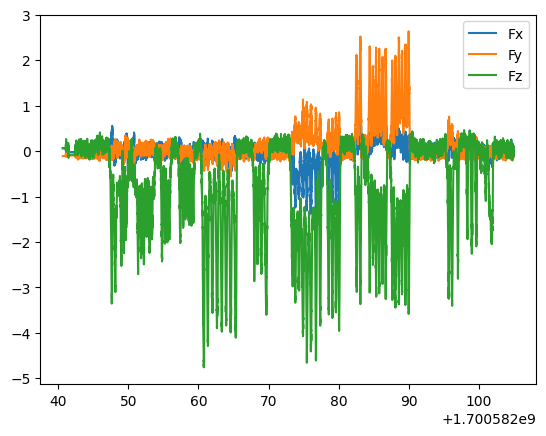

In [139]:
plt.plot(combined['t_wall'], combined['F_x'], label='Fx')
plt.plot(combined['t_wall'], combined['F_y'], label='Fy')
plt.plot(combined['t_wall'], combined['F_z'], label='Fz')
plt.legend()

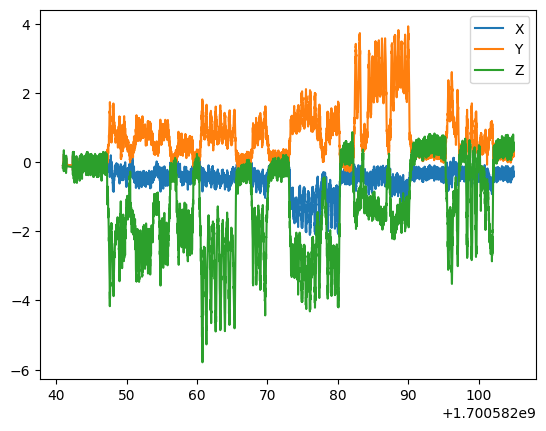

In [140]:
plt.plot(combined['t_wall'], combined['X'], label='X')
plt.plot(combined['t_wall'], combined['Y'], label='Y')
plt.plot(combined['t_wall'], combined['Z'], label='Z')
plt.legend()

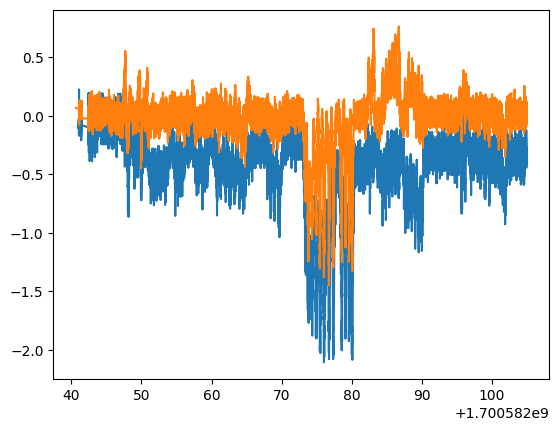

In [141]:
plt.plot(combined['t_wall'], combined['X'])
plt.plot(combined['t_wall'], combined['F_x'], label='Fz')

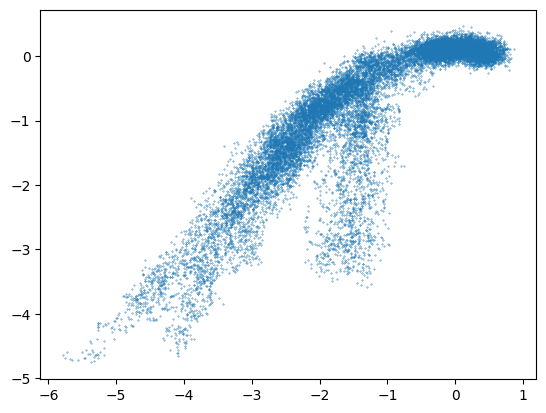

In [142]:
plt.scatter(combined['Z'], combined['F_z'], s=0.1)
Bz = lambda z: 1/(-5.5-z)**3 * 5

zs = np.linspace(-4.5, 0, 100)

# plt.plot(zs, [Bz(z) for z in zs], color='red')

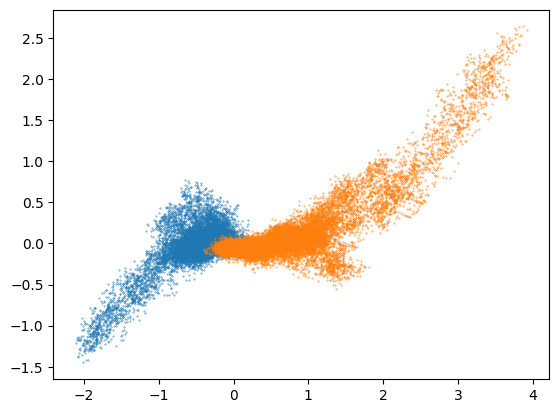

In [143]:
plt.scatter(combined['X'], combined['F_x'], s=0.1)
plt.scatter(combined['Y'], combined['F_y'], s=0.1)

### Add features

Only the magnitude (in XY plane and overall) seem to be useful

In [144]:
combined['TF_magnitude'] = np.sqrt(combined['F_x']**2 + combined['F_y']**2 + combined['F_z']**2)
combined['TF_magnitude_XY'] = np.sqrt(combined['F_x']**2 + combined['F_y']**2)

combined['sens_magnitude'] = np.sqrt(combined['X']**2 + combined['Y']**2 + combined['Z']**2)
combined['sens_magnitude_XY'] = np.sqrt(combined['X']**2 + combined['Y']**2)

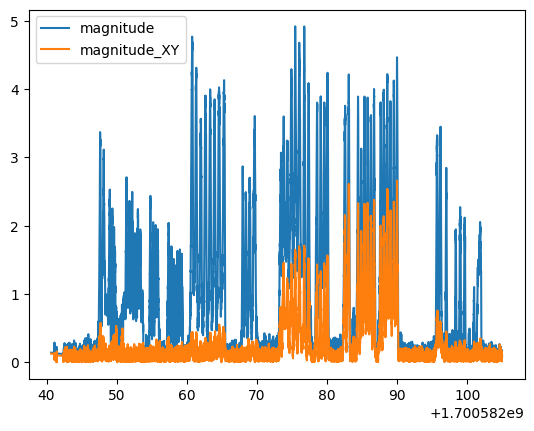

In [145]:
plt.plot(combined['t_wall'], combined['TF_magnitude'], label='magnitude')
plt.plot(combined['t_wall'], combined['TF_magnitude_XY'], label='magnitude_XY')
plt.legend()

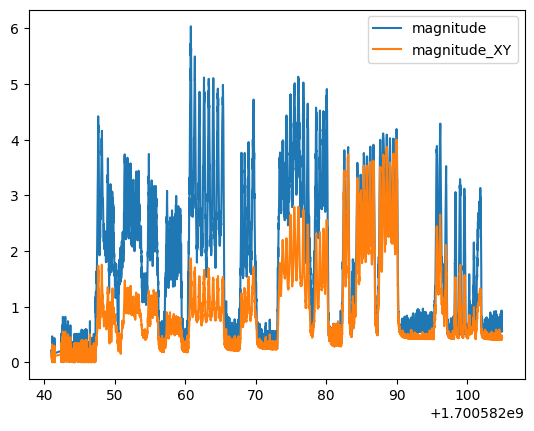

In [146]:
plt.plot(combined['t_wall'], combined['sens_magnitude'], label='magnitude')
plt.plot(combined['t_wall'], combined['sens_magnitude_XY'], label='magnitude_XY')
plt.legend()

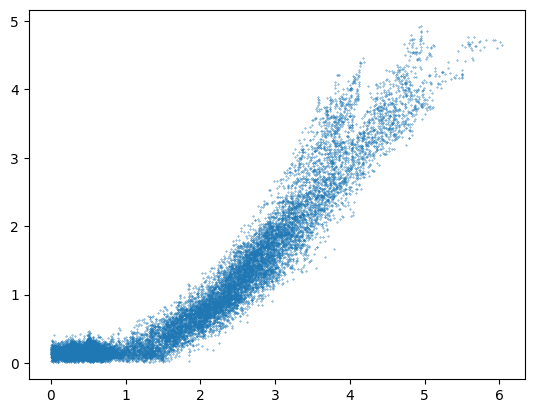

In [147]:
plt.scatter(combined['sens_magnitude'], combined['TF_magnitude'], s=0.1)

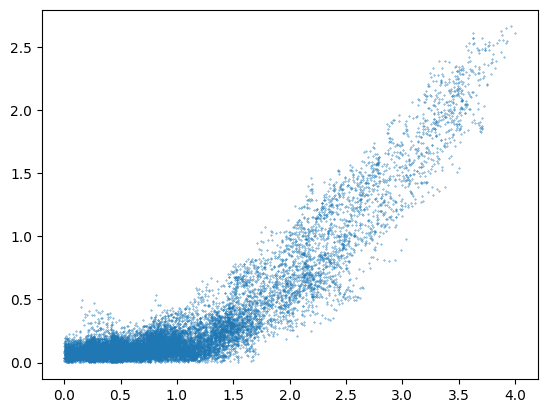

In [148]:
plt.scatter(combined['sens_magnitude_XY'], combined['TF_magnitude_XY'], s=0.1)

# Linear regression
First we try basic linear regression. 

In [149]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [150]:
X = combined[['X', 'Y', 'Z', 'sens_magnitude', 'sens_magnitude_XY']][1:]
Y = combined[['F_x', 'F_y', 'F_z', 'TF_magnitude', 'TF_magnitude_XY']][1:]

print(X.shape, Y.shape)

# Different model per thing
model = LinearRegression()

model.fit(X, Y)
print("Score: ", model.score(X, Y))
print("MSE: ", mean_squared_error(Y, model.predict(X)))


(18528, 5) (18528, 5)
Score:  0.8469560815115964
MSE:  0.05641768770424318


In [151]:
Y_pred = model.predict(X)

In [152]:
# Some functions
def plot_predictions(Y, Y_pred):
  
  subplot_index = Y.shape[1] * 100 + 11
  
  for i in range(Y.shape[1]):
    
    plt.subplot(subplot_index + i)
    plt.plot(Y[:,i], label='true')
    plt.plot(Y_pred[:,i], label='pred')

  plt.show()
  
def calculate_RMSE(Y, Y_pred):
  
  RMSE = np.zeros(Y.shape[1])
  
  for i in range(Y.shape[1]):
    RMSE[i] = np.sqrt(np.mean((Y[:,i] - Y_pred[:,i])**2))
    
  return RMSE

def calculate_error(Y, Y_pred):
    
    error = np.zeros(Y.shape)
    
    for i in range(Y.shape[1]):
      error[:, i] = np.abs(Y[:,i] - Y_pred[:,i])
      
    return error

def plot_curves(x):
  index = 1
  subplot_index = x.shape[1] * 100 + 11
  
  for i in range(x.shape[1]):
    plt.subplot(subplot_index + i)
    plt.plot(x[:, i], label='RMSE')
    
    index += 1

  plt.show()

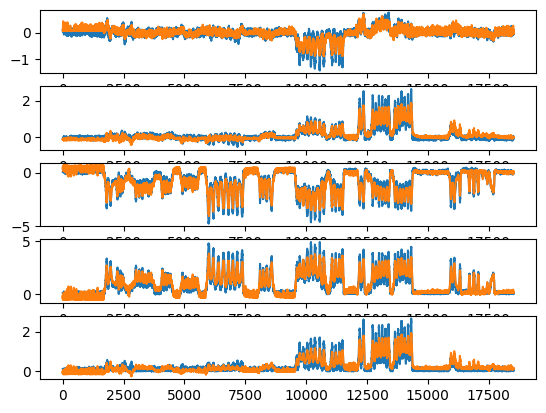

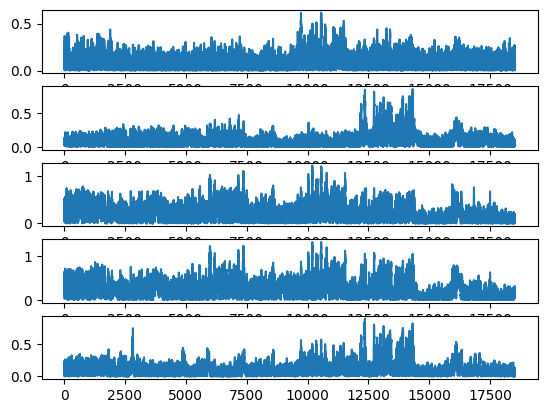

In [153]:
plot_predictions(Y.to_numpy(), Y_pred)
plot_curves(calculate_error(Y.to_numpy(), Y_pred))

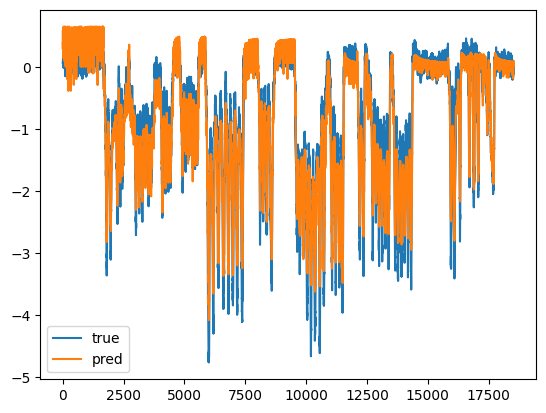

In [154]:
index = 2

plt.plot(Y.to_numpy()[:, index], label='true')
plt.plot(Y_pred[:, index], label='pred')
plt.legend()
# plt.xlim((6000,9000))

# HistBoostingRegression


In [155]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

In [156]:
# Make a custom (train, val) / test split
X = combined[['X', 'Y', 'Z', 'sens_magnitude', 'sens_magnitude_XY']][1:]
y = combined[['F_x']][1:]

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, shuffle=True)

# # First we take out all the parts that interest us
# ranges = [(2000, 2600), (3400, 4100), (4800, 5900), (6850, 7800), (8700, 9700)]
# indices = []

# for j in range(len(ranges)):

#   indices += [i for i in range(ranges[j][0], ranges[j][1])]
  
#   plt.plot(combined['t_wall'][ranges[j][0]:ranges[j][1]], combined['TF_magnitude'][ranges[j][0]:ranges[j][1]], label=f'{j}', color='green')
  
#   if j < len(ranges) - 1:
#     plt.plot(combined['t_wall'][ranges[j][1]:ranges[j+1][0]], combined['TF_magnitude'][ranges[j][1]:ranges[j+1][0]], label=f'{j}', color='red')
#   else:
#     plt.plot(combined['t_wall'][ranges[j][1]:], combined['TF_magnitude'][ranges[j][1]:], label=f'{j}', color='red')


In [157]:
param_grid = {
    "max_depth": [1, 2, 4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 5),
}

reg = HistGradientBoostingRegressor()

gridsearch = GridSearchCV(reg, param_grid=param_grid, verbose=10, return_train_score=True, n_jobs=8)


In [158]:
gridsearch.fit(X_train, y_train[:, 0])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START learning_rate=0.01, max_depth=1............................
[CV 2/5; 1/30] START learning_rate=0.01, max_depth=1............................
[CV 3/5; 1/30] START learning_rate=0.01, max_depth=1............................
[CV 4/5; 1/30] START learning_rate=0.01, max_depth=1............................
[CV 5/5; 1/30] START learning_rate=0.01, max_depth=1............................
[CV 1/5; 2/30] START learning_rate=0.01, max_depth=2............................
[CV 2/5; 2/30] START learning_rate=0.01, max_depth=2............................
[CV 3/5; 2/30] START learning_rate=0.01, max_depth=2............................
[CV 2/5; 1/30] END learning_rate=0.01, max_depth=1;, score=(train=0.540, test=0.528) total time=   0.1s
[CV 4/5; 2/30] START learning_rate=0.01, max_depth=2............................
[CV 5/5; 1/30] END learning_rate=0.01, max_depth=1;, score=(train=0.534, test=0.550) total time=   0.1s
[

[CV 3/5; 3/30] START learning_rate=0.01, max_depth=4............................
[CV 2/5; 2/30] END learning_rate=0.01, max_depth=2;, score=(train=0.653, test=0.637) total time=   0.1s
[CV 4/5; 3/30] START learning_rate=0.01, max_depth=4............................
[CV 1/5; 2/30] END learning_rate=0.01, max_depth=2;, score=(train=0.649, test=0.641) total time=   0.1s
[CV 5/5; 3/30] START learning_rate=0.01, max_depth=4............................
[CV 3/5; 2/30] END learning_rate=0.01, max_depth=2;, score=(train=0.648, test=0.655) total time=   0.1s
[CV 1/5; 4/30] START learning_rate=0.01, max_depth=6............................
[CV 4/5; 2/30] END learning_rate=0.01, max_depth=2;, score=(train=0.653, test=0.644) total time=   0.1s
[CV 2/5; 4/30] START learning_rate=0.01, max_depth=6............................
[CV 5/5; 2/30] END learning_rate=0.01, max_depth=2;, score=(train=0.649, test=0.660) total time=   0.1s
[CV 4/5; 4/30] START learning_rate=0.01, max_depth=6.......................

GridSearchCV(estimator=HistGradientBoostingRegressor(), n_jobs=8,
             param_grid={'learning_rate': array([0.01  , 0.0575, 0.105 , 0.1525, 0.2   ]),
                         'max_depth': [1, 2, 4, 6, 8, 10]},
             return_train_score=True, verbose=10)

In [159]:
results = gridsearch.cv_results_

train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print('Training accuracy {}'.format(train_score))
print('Validation accuracy: {}'.format(validation_score))

print('Best estimator:')
print(gridsearch.best_estimator_)

Training accuracy 0.9029007633967104
Validation accuracy: 0.875328509598497
Best estimator:
HistGradientBoostingRegressor(learning_rate=0.15250000000000002, max_depth=10)


[[0.53518094 0.64741989 0.71525146 0.73735322 0.73886463 0.73831643]
 [0.78896706 0.83751535 0.86286518 0.87148717 0.87293037 0.87294057]
 [0.81653519 0.84917844 0.86820598 0.87364828 0.8735846  0.87320545]
 [0.82375177 0.85312771 0.86941512 0.87450739 0.87354427 0.87532851]
 [0.82652332 0.85657374 0.87089827 0.87480604 0.87322154 0.87295718]]


/tmp/ipykernel_31479/1126520658.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(grid_param_1)
/tmp/ipykernel_31479/1126520658.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(grid_param_2)


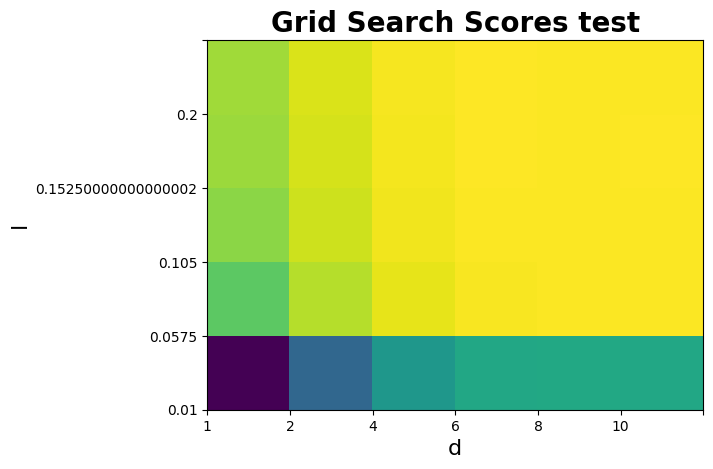

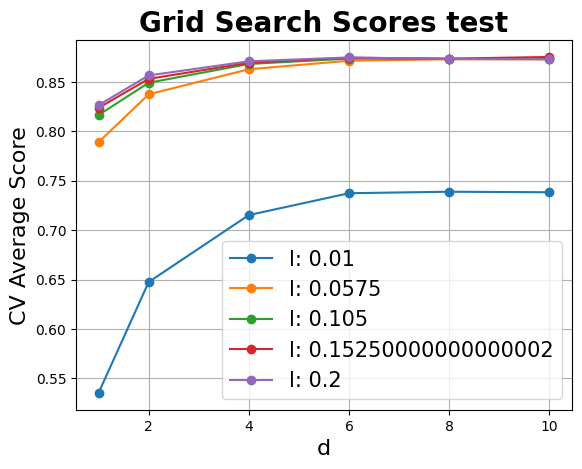

In [160]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, type='train'):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results[f'mean_{type}_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    print(scores_mean)

    _, ax = plt.subplots(1,1)
    ax.pcolor(scores_mean)
    ax.set_title(f"Grid Search Scores {type}", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel(name_param_2, fontsize=16)
    ax.set_xticklabels(grid_param_1)
    ax.set_yticklabels(grid_param_2)


    scores_sd = cv_results[f'std_{type}_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title(f"Grid Search Scores {type}", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
# plot_grid_search(gridsearch.cv_results_, param_grid['max_depth'], param_grid['learning_rate'], 'd', 'l', 'train')
plot_grid_search(gridsearch.cv_results_, param_grid['max_depth'], param_grid['learning_rate'], 'd', 'l', 'test')
plt.show()

In [161]:
def plot_learning_curve(sizes,train,val):
    train_scores_mean = np.mean(train, axis=1)
    train_scores_std = np.std(train, axis=1)
    val_scores_mean = np.mean(val, axis=1)
    val_scores_std = np.std(val, axis=1)

    _, axes = plt.subplots(1,)
    axes.grid()
    axes.fill_between(
        sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.fill_between(
        sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.plot(
        sizes, train_scores_mean, "o-", color="g", label="Training score"
    )
    axes.plot(
        sizes, val_scores_mean, "o-", color="r", label="Cross-validation score"
    )
    axes.set_ylim((0,1))
    axes.legend(loc="best")
    
    plt.show()
    return

[learning_curve] Training set sizes: [ 1482  4817  8152 11487 14822]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END ..................., score=(train=0.673, test=0.102) total time=   0.2s
[CV] END ..................., score=(train=0.584, test=0.082) total time=   0.3s
[CV] END ..................., score=(train=0.944, test=0.144) total time=   0.3s


[Parallel(n_jobs=4)]: Done   2 out of  25 | elapsed:    1.1s remaining:   12.3s


[CV] END ..................., score=(train=0.936, test=0.199) total time=   0.4s
[CV] END ..................., score=(train=0.287, test=0.006) total time=   0.2s
[CV] END ..................., score=(train=0.921, test=0.175) total time=   0.4s
[CV] END .................., score=(train=0.676, test=-0.409) total time=   0.3s
[CV] END .................., score=(train=0.936, test=-0.323) total time=   0.3s


[Parallel(n_jobs=4)]: Done   8 out of  25 | elapsed:    1.6s remaining:    3.5s


[CV] END .................., score=(train=0.945, test=-0.714) total time=   0.4s
[CV] END .................., score=(train=0.287, test=-0.334) total time=   0.2s
[CV] END .................., score=(train=0.918, test=-0.245) total time=   0.3s
[CV] END ..................., score=(train=0.669, test=0.268) total time=   0.3s
[CV] END ..................., score=(train=0.858, test=0.866) total time=   0.3s
[CV] END ..................., score=(train=0.854, test=0.865) total time=   0.4s
[CV] END .................., score=(train=0.287, test=-0.043) total time=   0.2s


[Parallel(n_jobs=4)]: Done  14 out of  25 | elapsed:    2.1s remaining:    1.7s


[CV] END ..................., score=(train=0.833, test=0.866) total time=   0.3s
[CV] END .................., score=(train=0.669, test=-0.665) total time=   0.3s
[CV] END .................., score=(train=0.579, test=-0.653) total time=   0.3s
[CV] END .................., score=(train=0.909, test=-0.516) total time=   0.3s
[CV] END .................., score=(train=0.287, test=-0.012) total time=   0.2s
[CV] END ..................., score=(train=0.890, test=0.371) total time=   0.3s


[Parallel(n_jobs=4)]: Done  20 out of  25 | elapsed:    2.6s remaining:    0.6s


[CV] END .................., score=(train=0.669, test=-0.458) total time=   0.3s
[CV] END .................., score=(train=0.579, test=-0.255) total time=   0.3s
[CV] END .................., score=(train=0.918, test=-0.406) total time=   0.3s
[CV] END ..................., score=(train=0.916, test=0.193) total time=   0.3s


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.0s finished


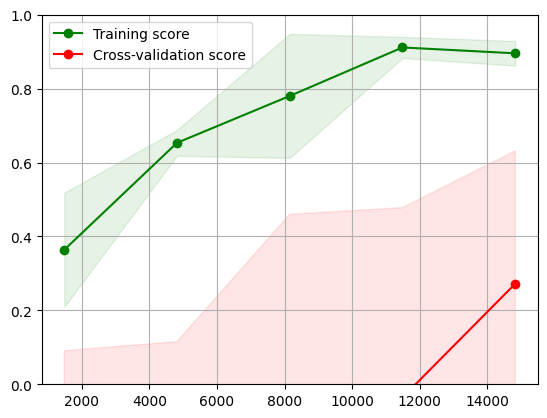

In [162]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(gridsearch.best_estimator_, X, y.to_numpy()[:, 0], n_jobs=4, verbose=5)
plot_learning_curve(train_sizes, train_scores, val_scores)


In [163]:
gridsearch.best_estimator_.score(X_test, y_test)

0.8852337094637003

In [164]:
Y_pred = gridsearch.best_estimator_.predict(X_test)

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(


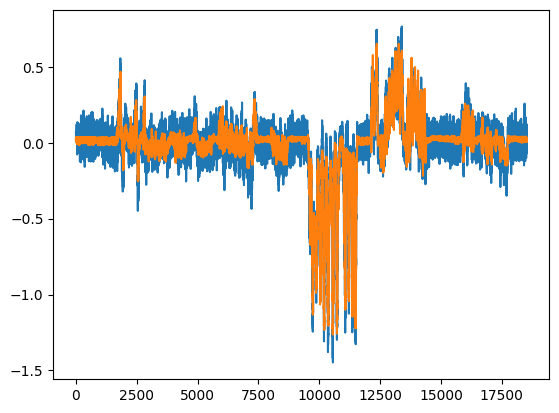

In [165]:
plt.plot(combined['F_x'], label='true')
plt.plot(gridsearch.best_estimator_.predict(X), label='pred')
# plt.xlim((6000, 8000))

## Creating a model for each component

In [166]:
regressors = []
columns = ['F_x', 'F_y', 'F_z']
for col in columns:
  
  # (Train/val) / test split
  X = combined[['X', 'Y', 'Z', 'sens_magnitude', 'sens_magnitude_XY']][1:]
  y = combined[[col]][1:]

  X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, shuffle=True)

  reg = HistGradientBoostingRegressor()

  gridsearch = GridSearchCV(reg, param_grid=param_grid, verbose=1, return_train_score=True, n_jobs=8)

  gridsearch.fit(X_train, y_train[:, 0])  
  
  print("Score: ", gridsearch.best_estimator_.score(X_test, y_test))
  
  regressors.append(gridsearch.best_estimator_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.8823521530781029
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9657852869358504
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Score:  0.9840017295558416


In [167]:
print(regressors)

[HistGradientBoostingRegressor(learning_rate=0.15250000000000002, max_depth=10), HistGradientBoostingRegressor(learning_rate=0.15250000000000002, max_depth=10), HistGradientBoostingRegressor(learning_rate=0.2, max_depth=10)]


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(


[[ 0.01665536  0.0213368   0.04154339 ...  0.00780502  0.00780502
   0.00780502]
 [-0.05200741 -0.03210952 -0.0516513  ... -0.06185914 -0.06185914
  -0.06185914]
 [ 0.08887509  0.09581947  0.08219972 ...  0.04225369  0.04225369
   0.04225369]]


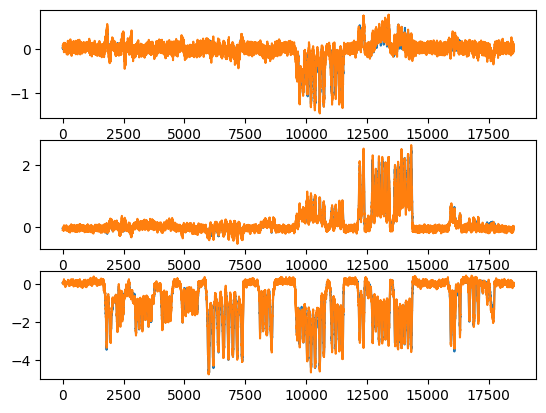

In [168]:
predictions = []
for reg in regressors:
  predictions.append(reg.predict(X)) 
  
print(np.array(predictions))
plot_predictions(np.array(predictions).T, combined[['F_x','F_y','F_z']].to_numpy())

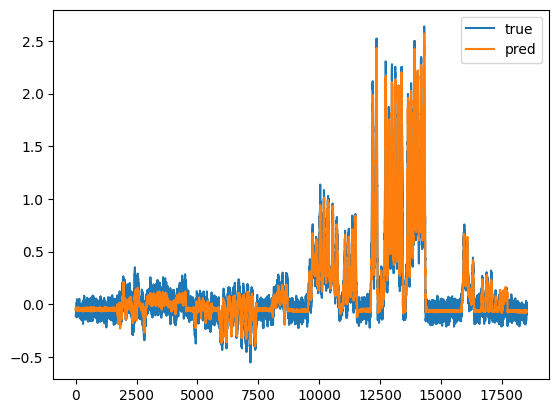

In [169]:
index = 1
letter = 'F_y'

plt.plot(combined[letter].to_numpy(), label='true')
plt.plot((np.array(predictions).T)[:, index], label='pred')
plt.legend()
# plt.xlim((11000, 15000))

In [170]:
import pickle

# Save the models to the folder
save_path = os.path.join(os.getcwd(), 'models', 'H1_5_sensor' + str(TAXEL_INDEX))

for col, reg in zip(columns, regressors):
  with open(os.path.join(save_path, col), 'wb') as f:
    pickle.dump(reg, f)

# MLPRegressor

In [398]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor

In [482]:
X = combined[['X', 'Y', 'Z', 'sens_magnitude', 'sens_magnitude_XY']][1:]
y = combined[['F_x', 'F_y', 'F_z']][1:]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1
)

reg = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, activation='relu', solver='adam', verbose=True)
reg.fit(X_train, y_train)

Iteration 1, loss = 0.28868041
Iteration 2, loss = 0.14084119
Iteration 3, loss = 0.11852400
Iteration 4, loss = 0.10613001
Iteration 5, loss = 0.09729583
Iteration 6, loss = 0.09122093
Iteration 7, loss = 0.08840173
Iteration 8, loss = 0.08738685
Iteration 9, loss = 0.08352604
Iteration 10, loss = 0.08187886
Iteration 11, loss = 0.08012806
Iteration 12, loss = 0.07984469
Iteration 13, loss = 0.07807515
Iteration 14, loss = 0.07646950
Iteration 15, loss = 0.07516233
Iteration 16, loss = 0.07458835
Iteration 17, loss = 0.07275754
Iteration 18, loss = 0.07286851
Iteration 19, loss = 0.07211271
Iteration 20, loss = 0.07192180
Iteration 21, loss = 0.07094516
Iteration 22, loss = 0.07033484
Iteration 23, loss = 0.07088318
Iteration 24, loss = 0.06902426
Iteration 25, loss = 0.06806351
Iteration 26, loss = 0.06704338
Iteration 27, loss = 0.06601536
Iteration 28, loss = 0.06682761
Iteration 29, loss = 0.06380340
Iteration 30, loss = 0.06372623
Iteration 31, loss = 0.06319346
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, verbose=True)

In [483]:
reg.score(X_test, y_test)

0.8528971152029233

In [484]:
Y_pred = reg.predict(X)

IndexError: index 3 is out of bounds for axis 1 with size 3

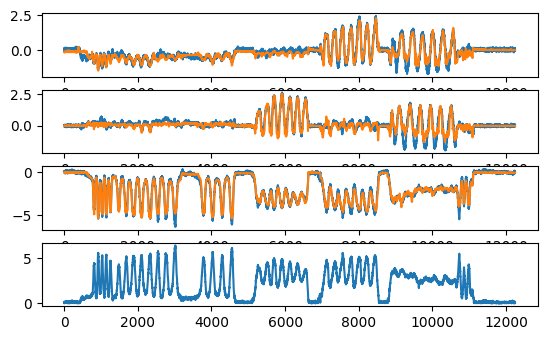

In [485]:
plot_predictions(Y.to_numpy(), Y_pred)

(6000.0, 9000.0)

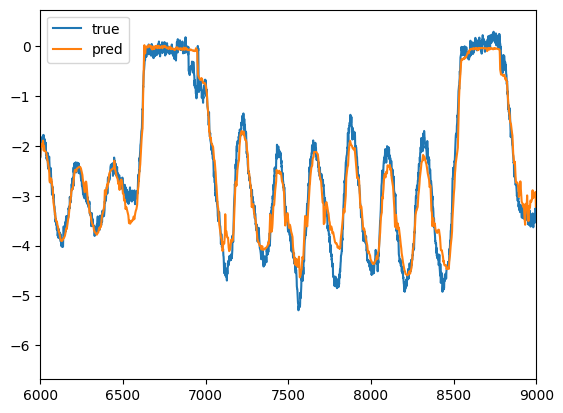

In [488]:
index = 2

plt.plot(Y.to_numpy()[:, index], label='true')
plt.plot(Y_pred[:, index], label='pred')
plt.legend()
plt.xlim((6000,9000))